In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import gymnasium as gym
env = gym.make("ALE/KungFuMaster-v5")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [88]:
def transform(state):
    out = torch.from_numpy(state).permute(2, 1, 0)
    out = out.float() / 255.0
    out = F.interpolate(out.unsqueeze(0), size=(96, 128), mode='bilinear').squeeze(0)
    out = out[0] * 0.2126 + out[1] * 0.7152 + out[2] * 0.1140 # grayscale
    out = out[:, 32:128] # crop to game field
    return out.unsqueeze(0).half()

def readhealth(state):
    return (state[45, 50:82, 1] > 128).astype(float).mean()

def rollout(env, agent, max_steps=1000):
    result = []
    state, info = env.reset()
    state = transform(state)
    health = info['lives']
    for _ in range(max_steps):
        action = agent(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        next_health = 0 if info['lives'] == 0 else (info['lives'] - 1) + readhealth(next_state)
        reward += (next_health - health) * 100 # penalize health loss

        result.append((state, action, reward))
        state = transform(next_state)
        health = next_health
        if terminated or truncated:
            break
    return result

def batches(env, agent, batch_size, num_rollouts, max_steps=1000, reward_discount=0.99):
    games = []
    gamea = []
    gamer = []
    for _ in range(num_rollouts):
        game = rollout(env, agent, max_steps)
        # score using discounted rewards
        acc_reward = 0
        for i in range(len(game) - 1, -1, -1):
            acc_reward = game[i][2] + reward_discount * acc_reward
            games.append(game[i][0])
            gamea.append(game[i][1])
            gamer.append(acc_reward)

    while len(games) >= batch_size:
        yield games[:batch_size], gamea[:batch_size], gamer[:batch_size]
        games = games[batch_size:]
        gamea = gamea[batch_size:]
        gamer = gamer[batch_size:]

def agent(state, net, device):
    state = state.float().to(device)
    pred = net(state)
    assert(len(pred.shape) == 1)
    prob = F.softmax(pred, dim=0)
    act = torch.multinomial(prob, 1)
    return act.item()

def agentk(state, net, device, topk):
    state = state.float().to(device)
    pred = net(state)
    assert(len(pred.shape) == 1)
    topv, topi = pred.topk(topk)
    prob = F.softmax(topv, dim=0)
    act = torch.multinomial(prob, 1)
    return topi[act.item()].item()

In [ ]:
class AtariNet(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(torch.prod(torch.tensor(o.size())))

    def forward(self, x):
        conv_out = self.conv(x)
        # flatten each sample in the batch
        conv_out = conv_out.view(x.shape[0], -1) if len(x.shape) == 4 else conv_out.flatten()
        pred = self.fc(conv_out)
        return pred

Epoch 0 took 38.49s, reward: 16.92, loss: 45.41
Epoch 1 took 40.46s, reward: 26.57, loss: 69.91
Epoch 2 took 40.69s, reward: 22.23, loss: 58.46
Epoch 3 took 42.02s, reward: 69.72, loss: 178.20
Epoch 4 took 44.58s, reward: 98.04, loss: 247.85
Epoch 5 took 43.90s, reward: 98.91, loss: 246.24
Epoch 6 took 45.22s, reward: 106.84, loss: 265.21
Epoch 7 took 44.77s, reward: 108.76, loss: 269.43
Epoch 8 took 45.09s, reward: 99.47, loss: 247.75
Epoch 9 took 46.84s, reward: 144.90, loss: 359.09
Epoch 10 took 46.91s, reward: 123.18, loss: 304.44
Epoch 11 took 45.57s, reward: 109.34, loss: 272.82
Epoch 12 took 45.37s, reward: 127.85, loss: 315.33
Epoch 13 took 45.01s, reward: 150.24, loss: 362.54
Epoch 14 took 45.02s, reward: 144.62, loss: 348.27
Epoch 15 took 44.67s, reward: 149.19, loss: 359.34
Epoch 16 took 44.28s, reward: 143.92, loss: 344.84
Epoch 17 took 42.53s, reward: 151.92, loss: 367.47
Epoch 18 took 37.65s, reward: 140.65, loss: 341.69
Epoch 19 took 37.50s, reward: 153.71, loss: 369.07


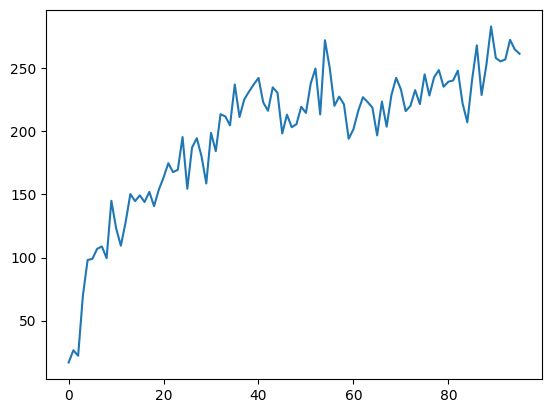

In [73]:
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AtariNet((1, 96, 96), env.action_space.n)
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)

num_epochs = 96
num_rollouts = 32
batch_size = 128

epoch_rewards = []

for epoch in range(num_epochs):
    epoch_reward = 0
    epoch_loss = 0
    epoch_start = time.time()
    num_batches = 0

    for bs, ba, br in batches(env, lambda s: agent(s, net, device), batch_size=batch_size, num_rollouts=num_rollouts):
        bs = torch.stack(bs)
        ba = torch.tensor(ba, dtype=torch.long)
        br = torch.tensor(br, dtype=torch.float)

        bs = bs.float()
        bs, ba, br = bs.to(device), ba.to(device), br.to(device)

        pred = net(bs)
        log_prob = F.log_softmax(pred, dim=-1)
        loss = (-log_prob[torch.arange(0, ba.shape[0]), ba] * br).mean()

        epoch_reward += br.mean().item()
        epoch_loss += loss.item()
        num_batches += 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_reward /= num_batches
    epoch_loss /= num_batches

    print(f'Epoch {epoch} took {time.time() - epoch_start:.2f}s, reward: {epoch_reward:.2f}, loss: {epoch_loss:.2f}')

    epoch_rewards.append(epoch_reward)

    torch.save(net.state_dict(), 'kungfu.pth')

plt.plot(epoch_rewards)

In [114]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = AtariNet((1, 96, 96), env.action_space.n).to(device)
net.load_state_dict(torch.load('kungfu.pth', weights_only=True))

testenv = gym.make("ALE/KungFuMaster-v5")
observation, info = testenv.reset()
total_steps = 0
total_reward = 0

while True:
    action = agent(transform(observation), net, device)
    observation, reward, terminated, truncated, info = testenv.step(action)
    total_reward += reward
    total_steps += 1

    if terminated or truncated:
        break

testenv.close()

print(f'Total reward: {total_reward}, steps {total_steps}')

Total reward: 7500.0, steps 2020
